In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import pytz
from pvlive_api import PVLive
from typing import Final
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = [20, 15]

In [2]:
FILENAME: Final[str] = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
ocf_training_dataset = xr.open_dataset(FILENAME, engine="zarr")
ocf_training_dataset

<xarray.Dataset>
Dimensions:                (datetime_gmt: 150865, gsp_id: 318)
Coordinates:
  * datetime_gmt           (datetime_gmt) datetime64[ns] 2014-01-01 ... 2022-...
  * gsp_id                 (gsp_id) int64 0 1 2 3 4 5 ... 313 314 315 316 317
Data variables:
    generation_mw          (datetime_gmt, gsp_id) float64 ...
    installedcapacity_mwp  (datetime_gmt, gsp_id) float64 ...

In [3]:
pvl = PVLive()
national_from_pv_live_api = pvl.between(
    start=datetime(2022, 6, 1, 0, 30, tzinfo=pytz.utc),
    end=datetime(2023, 4, 26, tzinfo=pytz.utc),
    extra_fields="installedcapacity_mwp",
    dataframe=True,
).set_index("datetime_gmt").drop(columns="gsp_id")
national_from_pv_live_api

,generation_mw,installedcapacity_mwp
datetime_gmt,,
2022-07-01 00:30:00+00:00,0.000000,13861.223
2022-07-01 00:00:00+00:00,0.000000,13861.223
2022-06-30 23:30:00+00:00,0.000000,13858.388
2022-06-30 23:00:00+00:00,0.000000,13858.388
2022-06-30 22:30:00+00:00,0.000000,13858.388
...,...,...
2023-03-28 07:30:00+00:00,274.630000,14284.648
2023-03-28 07:00:00+00:00,123.695000,14284.648
2023-03-28 06:30:00+00:00,10.118700,14284.648


In [4]:
national_gw_from_pv_live_api = national_from_pv_live_api.generation_mw / 1E3

In [5]:
def get_gsp_data_extracted_from_ocf_prod_db() -> pd.DataFrame:
    dfs = []
    filenames = ["gsp0.csv", "gsp1-50.csv", "gsp51-100.csv", "gsp101-150.csv", "gsp201-250.csv", "gsp251-300.csv", "gsp301-350.csv"]
    for start_gsp_id in range(151, 200, 10):
        filenames.append(f"gsp{start_gsp_id}-{start_gsp_id+9}.csv")

    for filename in filenames:
        full_filename = f"~/data/PV/PV_Live/from_OCF_production_database/{filename}"
        print(full_filename, flush=True)
        df = pd.read_csv(
            full_filename,
            header=0,
            names=["created_utc", "regime", "solar_generation_kw", "datetime_utc", "gsp_id", "gsp_name", "region_name", "installed_capacity_mw"],
            parse_dates=["datetime_utc"],
            index_col="datetime_utc",
            usecols=["datetime_utc", "regime", "solar_generation_kw", "gsp_id", "installed_capacity_mw"],
            dtype={"regime": "category", "gsp_id": np.int16, "solar_generation_kw": np.float32},
            ).tz_localize("UTC")
        df.solar_generation_kw /= 1E6
        df.rename({"solar_generation_kw": "solar_generation_gw"}, axis=1, inplace=True)
        dfs.append(df)
    return pd.concat(dfs)

pvl_gsp_gw_from_ocf_prod_db = get_gsp_data_extracted_from_ocf_prod_db()

~/data/PV/PV_Live/from_OCF_production_database/gsp0.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp1-50.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp51-100.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp101-150.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp201-250.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp251-300.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp301-350.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp151-160.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp161-170.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp171-180.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp181-190.csv
~/data/PV/PV_Live/from_OCF_production_database/gsp191-200.csv


In [6]:
intraday_mask = pvl_gsp_gw_from_ocf_prod_db.regime == "in-day"
intraday_from_ocf_prod_db = pvl_gsp_gw_from_ocf_prod_db.loc[intraday_mask]
updated_from_ocf_prod_db = pvl_gsp_gw_from_ocf_prod_db.loc[~intraday_mask]

def get_national(df: pd.DataFrame) -> pd.Series:
    return df.loc[df.gsp_id == 0].solar_generation_gw

def get_sum_of_gsps(df: pd.DataFrame) -> pd.Series:
    return df.loc[df.gsp_id != 0].groupby("datetime_utc").solar_generation_gw.sum()

intraday_national_from_ocf_prod_db = get_national(intraday_from_ocf_prod_db)
updated_national_from_ocf_prod_db = get_national(updated_from_ocf_prod_db)
intraday_sum_of_gsps_from_ocf_prod_db = get_sum_of_gsps(intraday_from_ocf_prod_db)
updated_sum_of_gsps_from_ocf_prod_db = get_sum_of_gsps(updated_from_ocf_prod_db)


(0.0, 10.0)

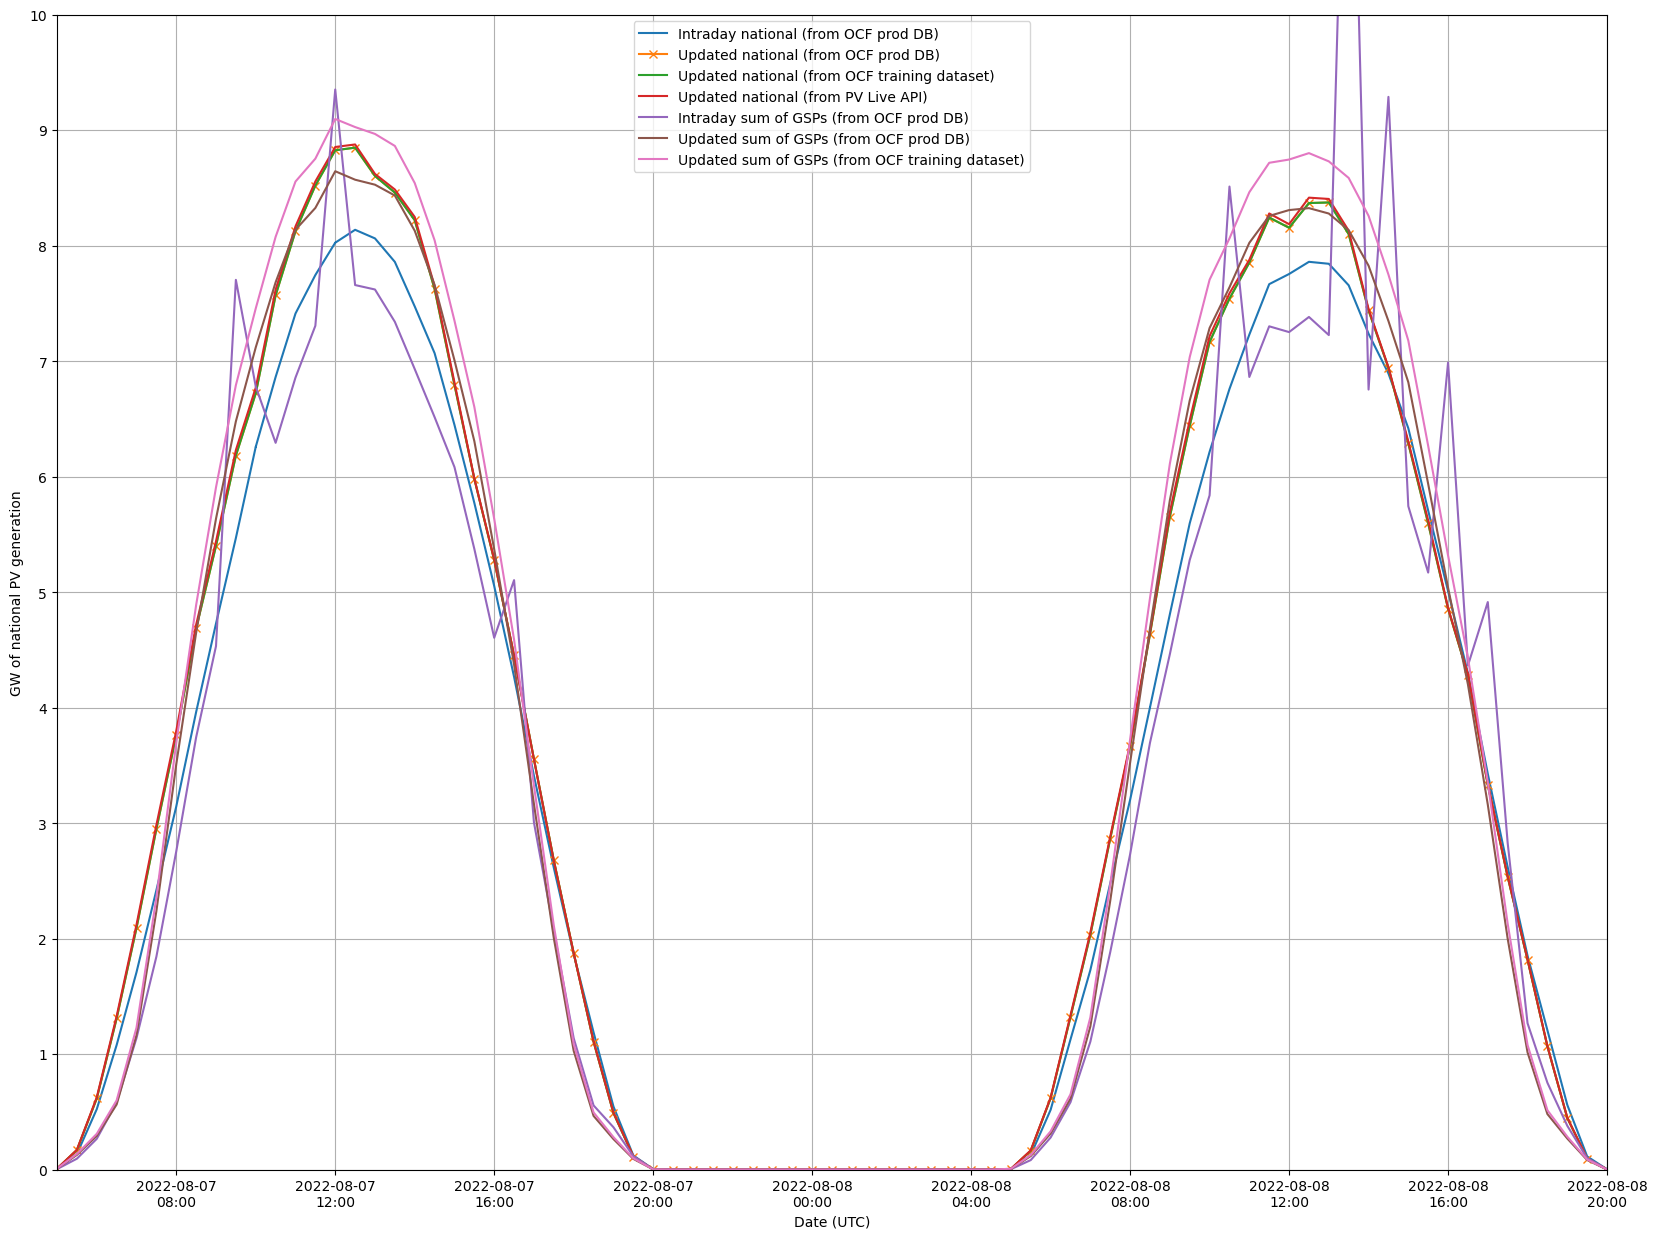

In [8]:
PLOT_SUM_OF_GSPS: Final[bool] = True

START_DATE: Final[str] = "2022-08-07 05:00"
END_DATE: Final[str] = "2022-08-08 20:00"

fig, ax = plt.subplots()

ax.plot(
    intraday_national_from_ocf_prod_db[START_DATE:END_DATE],
    label="Intraday national (from OCF prod DB)",
)

ax.plot(
    updated_national_from_ocf_prod_db[START_DATE:END_DATE],
    label="Updated national (from OCF prod DB)",
    marker="x",
)

ax.plot(
    ocf_training_dataset.sel(gsp_id=0, datetime_gmt=slice(START_DATE, END_DATE))["generation_mw"].to_series() / 1E3,
    label="Updated national (from OCF training dataset)",
)

ax.plot(
    national_gw_from_pv_live_api[START_DATE:END_DATE],
    label="Updated national (from PV Live API)",
)

if PLOT_SUM_OF_GSPS:
    ax.plot(
        intraday_sum_of_gsps_from_ocf_prod_db[START_DATE:END_DATE],
        label="Intraday sum of GSPs (from OCF prod DB)",
    )

    ax.plot(
        updated_sum_of_gsps_from_ocf_prod_db[START_DATE:END_DATE],
        label="Updated sum of GSPs (from OCF prod DB)",
    )
    
    ax.plot(
        ocf_training_dataset.sel(gsp_id=slice(1, None), datetime_gmt=slice(START_DATE, END_DATE))["generation_mw"].sum("gsp_id").to_series() / 1E3,
        label="Updated sum of GSPs (from OCF training dataset)",
    )

ax.legend()
ax.grid()
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_ylabel("GW of national PV generation")
ax.set_xlabel("Date (UTC)")
ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.set_xlim(
    mdates.datestr2num(START_DATE),
    mdates.datestr2num(END_DATE),  
)
ax.set_ylim([0, 10])

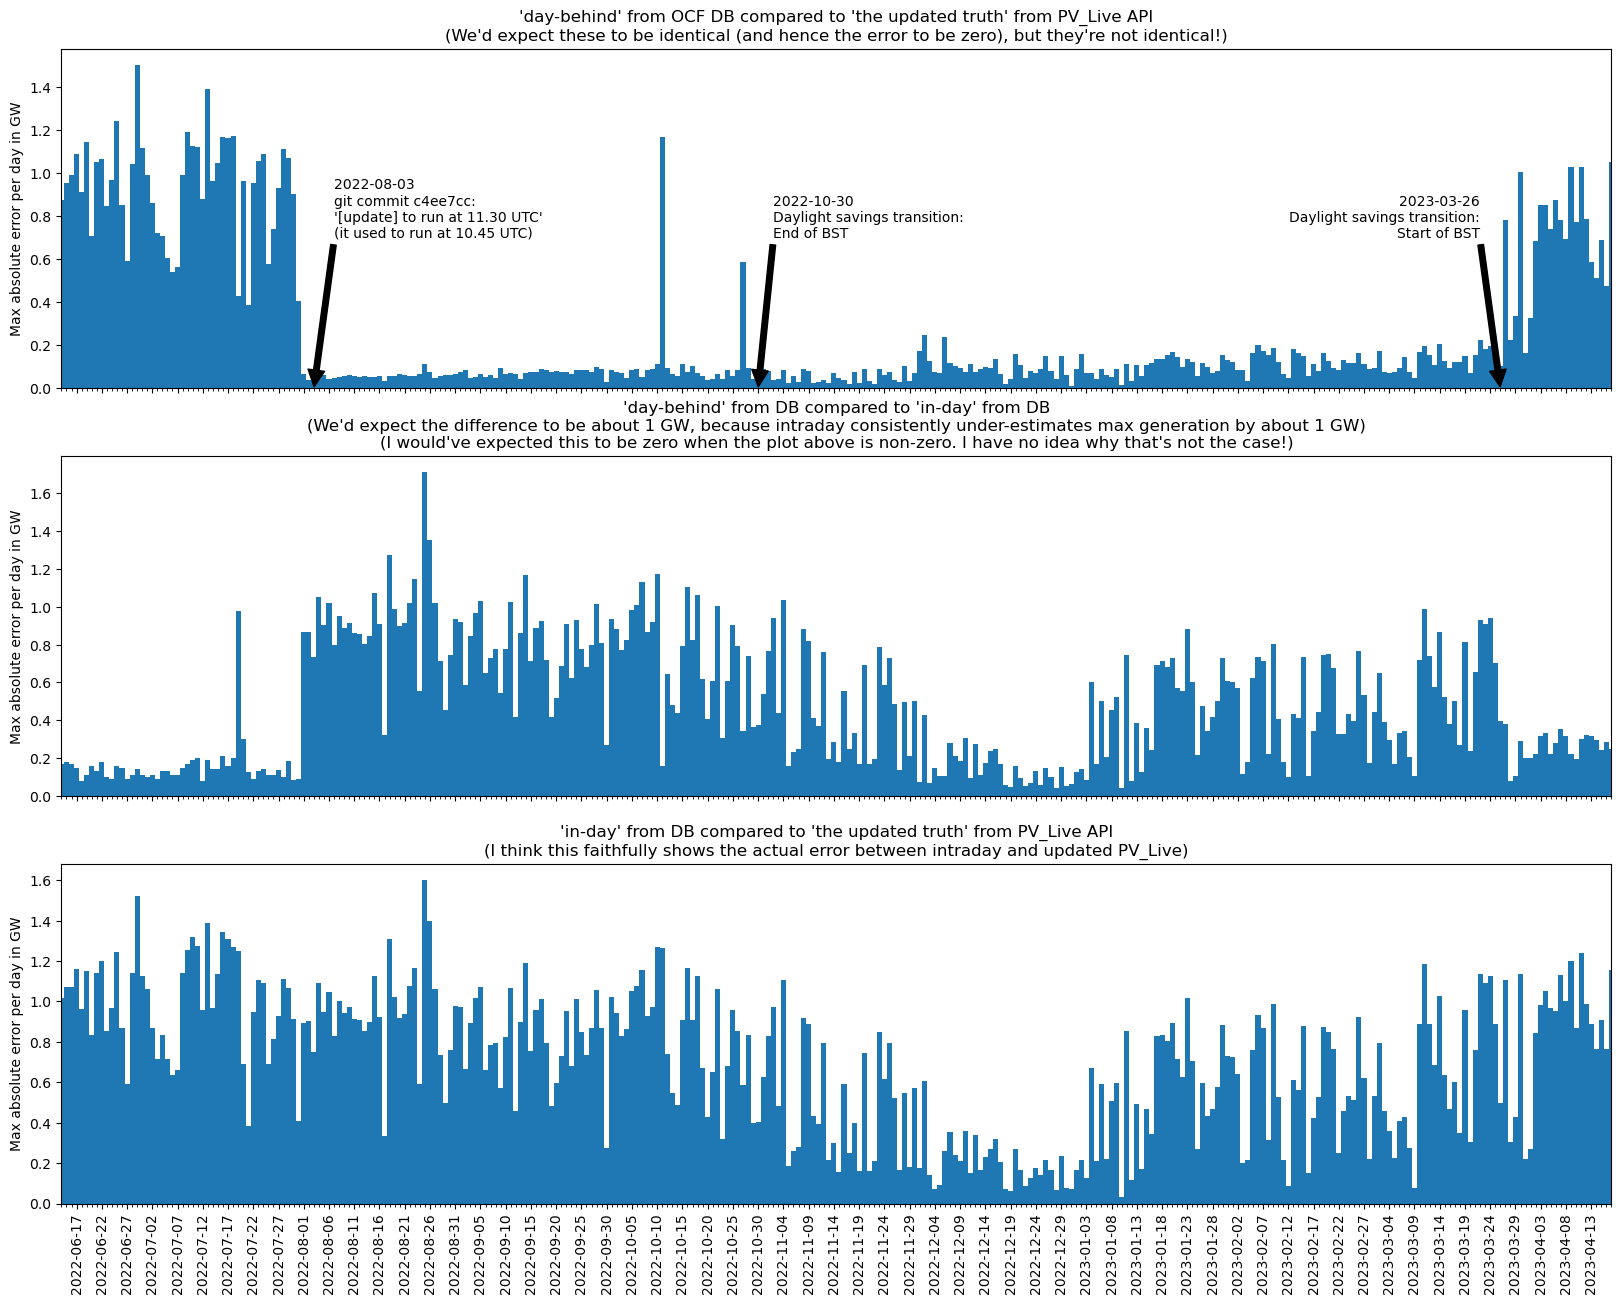

In [9]:
SIMPLE_PLOT: Final[bool] = False
BAR_KWARGS: Final[dict] = dict(
    width=1,
    linewidth=0,
)

fig, axes = plt.subplots(
    nrows=1 if SIMPLE_PLOT else 3,
    sharex=True,
)

ax = axes if SIMPLE_PLOT else axes[0]
ax.set_title("'day-behind' from OCF DB compared to 'the updated truth' from PV_Live API\n(We'd expect these to be identical (and hence the error to be zero), but they're not identical!)")
errors_updated = (updated_national_from_ocf_prod_db - national_gw_from_pv_live_api).dropna().abs().resample("D").max()
ax.bar(
    x=errors_updated.index,
    height=errors_updated,
    **BAR_KWARGS,

)
ax.set_ylabel("Max absolute error per day in GW")

# Annotation about git commit:
ax.annotate(
    "2022-08-03\ngit commit c4ee7cc:\n'[update] to run at 11.30 UTC'\n(it used to run at 10.45 UTC)",
    xy=(pd.Timestamp("2022-08-03"), 0.0),
    xytext=(pd.Timestamp("2022-08-07"), 0.7),
    arrowprops=dict(facecolor='black', shrink=0.01),    
)

# Annotation about BST ending:
ax.annotate(
    "2022-10-30\nDaylight savings transition:\nEnd of BST",
    xy=(pd.Timestamp("2022-10-30"), 0.0),
    xytext=(pd.Timestamp("2022-11-02"), 0.7),
    arrowprops=dict(facecolor='black', shrink=0.01),    
)

# Annotation about BST starting:
ax.annotate(
    "2023-03-26\nDaylight savings transition:\nStart of BST",
    xy=(pd.Timestamp("2023-03-26"), 0),
    xytext=(pd.Timestamp("2023-03-22"), 0.7),
    arrowprops=dict(facecolor='black', shrink=0.01),
    horizontalalignment='right',
)

if not SIMPLE_PLOT:
    ax = axes[1]
    ax.set_title("'day-behind' from DB compared to 'in-day' from DB\n(We'd expect the difference to be about 1 GW, because intraday consistently under-estimates max generation by about 1 GW)\n(I would've expected this to be zero when the plot above is non-zero. I have no idea why that's not the case!)")
    errors = (updated_national_from_ocf_prod_db - intraday_national_from_ocf_prod_db).dropna().abs().resample("D").max()
    ax.bar(
        x=errors.index,
        height=errors,
        **BAR_KWARGS,
    )
    ax.set_ylabel("Max absolute error per day in GW")

    ax = axes[2]
    ax.set_title("'in-day' from DB compared to 'the updated truth' from PV_Live API\n(I think this faithfully shows the actual error between intraday and updated PV_Live)")
    errors = (intraday_national_from_ocf_prod_db - national_gw_from_pv_live_api).dropna().abs().resample("D").max()
    ax.bar(
        x=errors.index,
        height=errors,
    **BAR_KWARGS,
    )
    ax.set_ylabel("Max absolute error per day in GW")

ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlim([
    errors_updated.index[0],
    errors_updated.index[-10],
]);

## Errors between PV_Live initial estimate and updated estimate

In [10]:
plt.rcParams['figure.figsize'] = [10, 5]

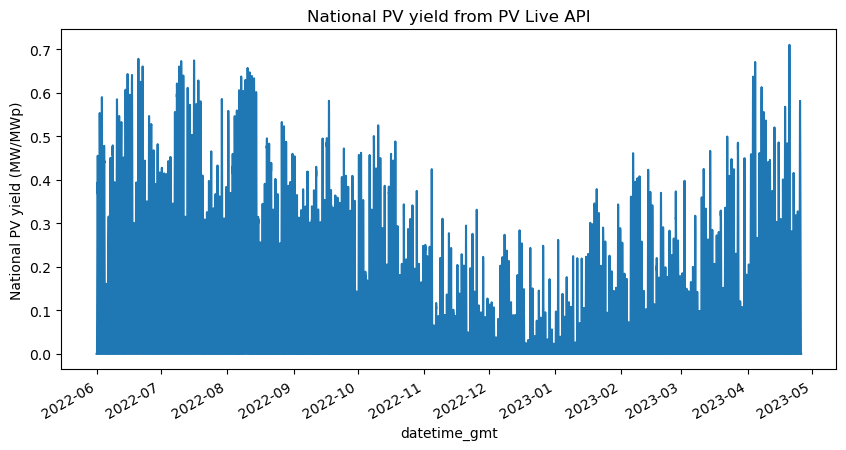

In [11]:
national_yield_from_pv_live_api = national_from_pv_live_api.generation_mw / national_from_pv_live_api.installedcapacity_mwp
ax = national_yield_from_pv_live_api.plot()
ax.set_title("National PV yield from PV Live API")
ax.set_ylabel("National PV yield (MW/MWp)");

In [12]:
def get_initial_estimate_of_national_yield_from_ocf_prod_db(df: pd.DataFrame) -> pd.Series:
    in_day_national_gw = pvl_gsp_gw_from_ocf_prod_db.query("gsp_id == 0 and regime == 'in-day'")
    return (in_day_national_gw.solar_generation_gw * 1E3) / in_day_national_gw.installed_capacity_mw

initial_national_yield_from_ocf_prod_db = get_initial_estimate_of_national_yield_from_ocf_prod_db(pvl_gsp_gw_from_ocf_prod_db)

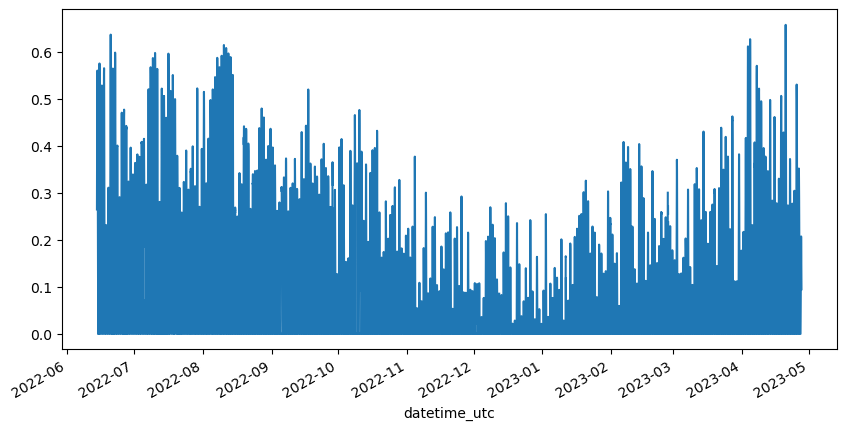

In [13]:
initial_national_yield_from_ocf_prod_db.plot();

In [36]:
error = initial_national_yield_from_ocf_prod_db - national_yield_from_pv_live_api
error = error.dropna()

## Absolute error (and MAE)

Text(0.5, 1.0, 'Absolute error between initial estimate of national PV yield and updated estimate')

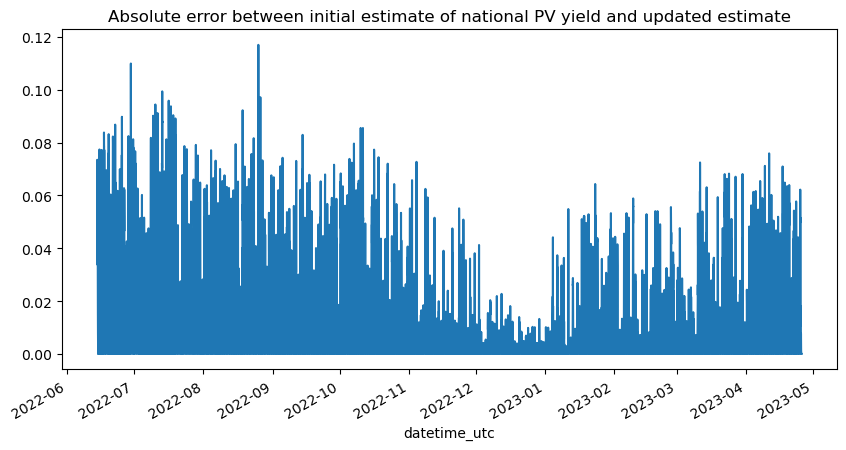

In [37]:
abs_error = error.abs().dropna()
ax = abs_error.plot()
ax.set_title("Absolute error between initial estimate of national PV yield and updated estimate")

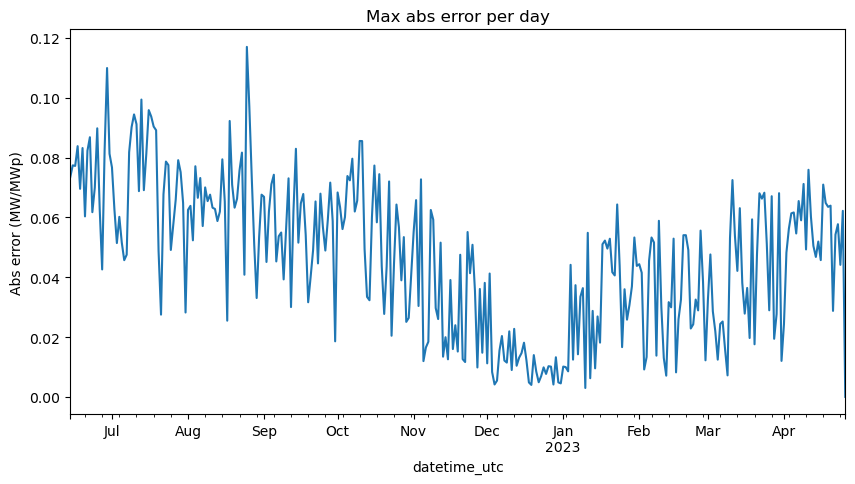

In [16]:
ax = abs_error.resample("D").max().plot()
ax.set_title("Max abs error per day")
ax.set_ylabel("Abs error (MW/MWp)");

In [17]:
abs_error.mean()

0.009785276717045504

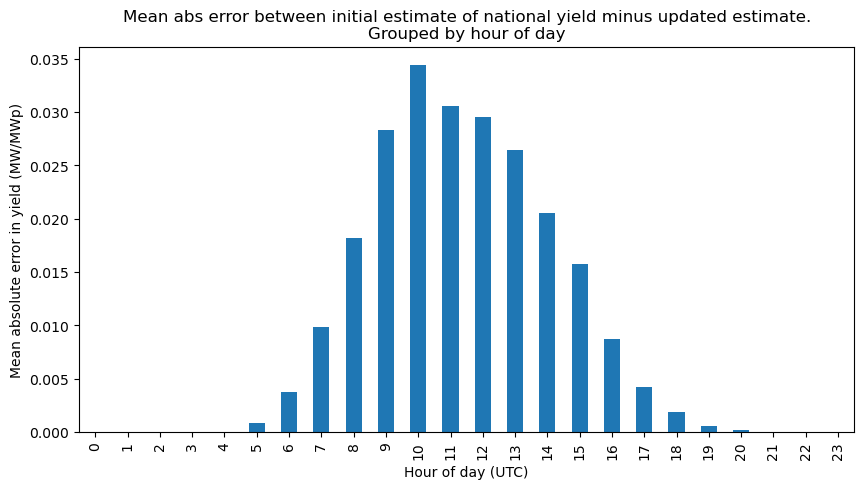

In [18]:
ax = abs_error.groupby(abs_error.index.hour).mean().plot.bar(figsize=(10, 5))
ax.set_title("Mean abs error between initial estimate of national yield minus updated estimate.\nGrouped by hour of day")
ax.set_ylabel("Mean absolute error in yield (MW/MWp)")
ax.set_xlabel("Hour of day (UTC)");

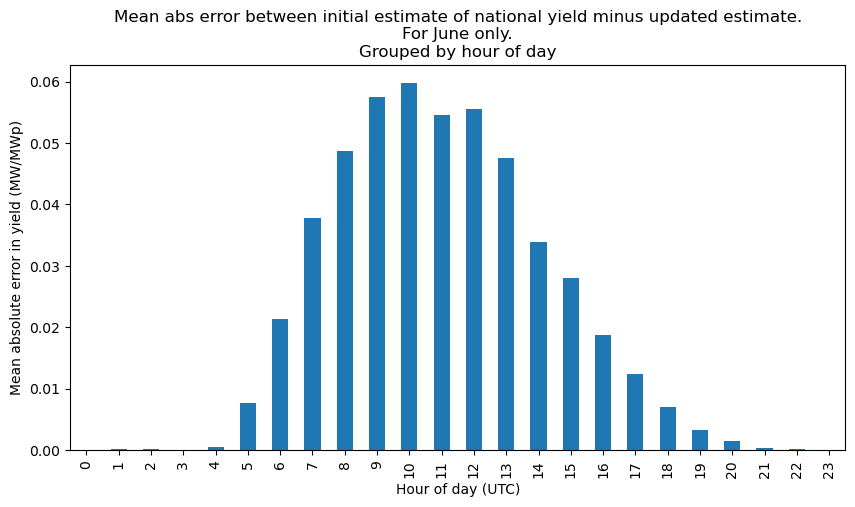

In [19]:
bias_error_for_month = abs_error.loc[abs_error.index.month == 6]
ax = bias_error_for_month.groupby(bias_error_for_month.index.hour).mean().plot.bar(figsize=(10, 5))
ax.set_title("Mean abs error between initial estimate of national yield minus updated estimate.\nFor June only.\nGrouped by hour of day")
ax.set_ylabel("Mean absolute error in yield (MW/MWp)")
ax.set_xlabel("Hour of day (UTC)");

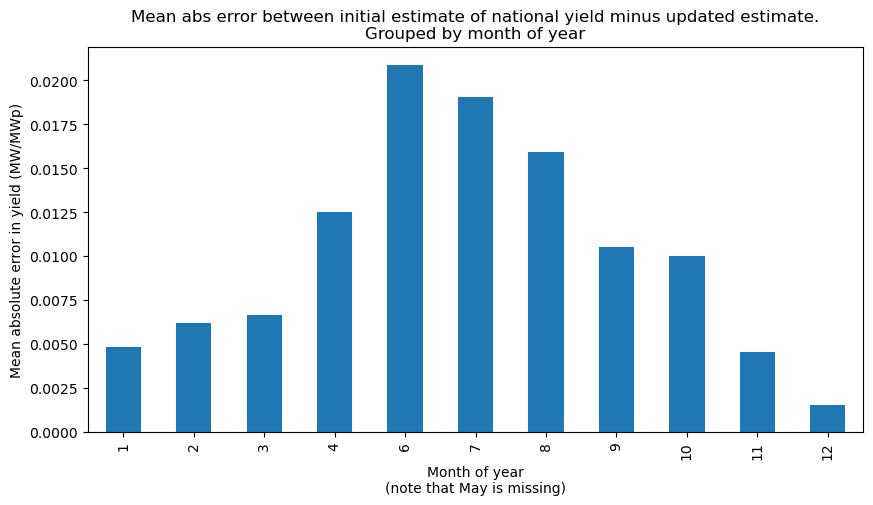

In [20]:
ax = abs_error.groupby(abs_error.index.month).mean().plot.bar(figsize=(10, 5))
ax.set_title("Mean abs error between initial estimate of national yield minus updated estimate.\nGrouped by month of year")
ax.set_ylabel("Mean absolute error in yield (MW/MWp)")
ax.set_xlabel("Month of year\n(note that May is missing)");

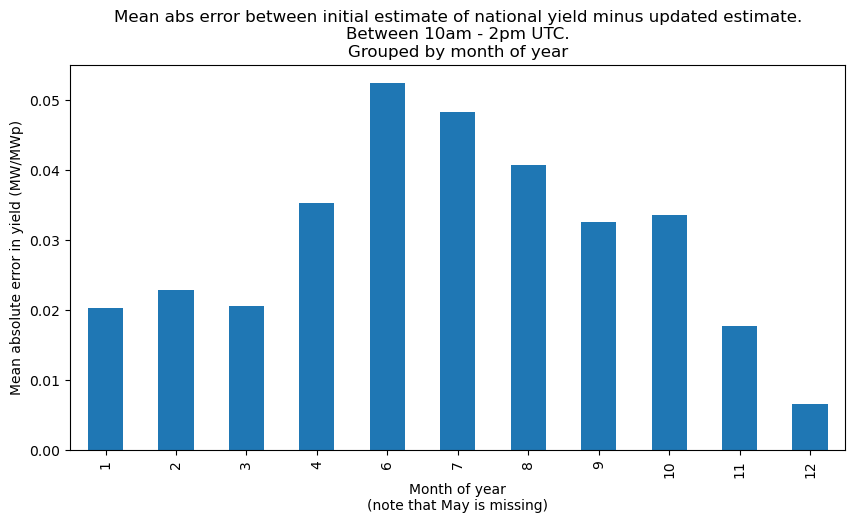

In [21]:
abs_error_in_daylight = abs_error.between_time("10:00", "14:00")
ax = abs_error_in_daylight.groupby(abs_error_in_daylight.index.month).mean().plot.bar(figsize=(10, 5))
ax.set_title("Mean abs error between initial estimate of national yield minus updated estimate.\nBetween 10am - 2pm UTC.\nGrouped by month of year")
ax.set_ylabel("Mean absolute error in yield (MW/MWp)")
ax.set_xlabel("Month of year\n(note that May is missing)");

Text(0, 0.5, 'Absolute error')

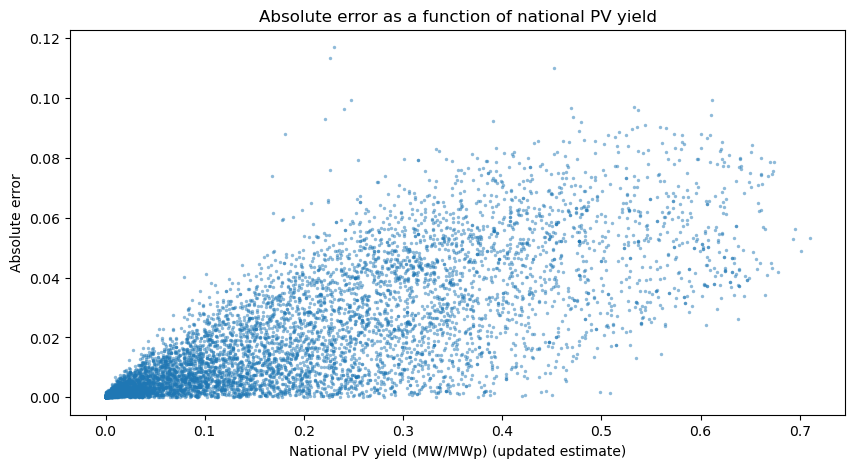

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(
    x=national_yield_from_pv_live_api.loc[abs_error.index],
    y=abs_error,
    alpha=0.5,
    linewidths=0,
    s=6,
)
ax.set_title("Absolute error as a function of national PV yield")
ax.set_xlabel("National PV yield (MW/MWp) (updated estimate)")
ax.set_ylabel("Absolute error")

Text(0, 0.5, 'Absolute error')

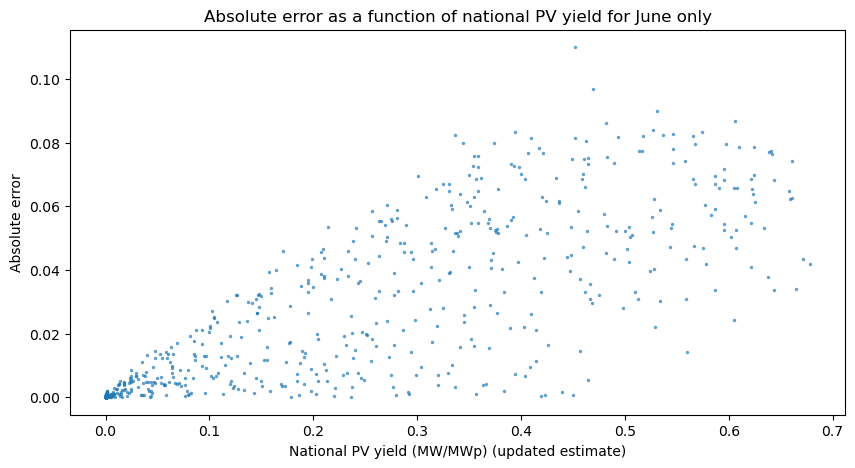

In [23]:
abs_error_subset = abs_error.loc[abs_error.index.month == 6]

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(
    x=national_yield_from_pv_live_api.loc[abs_error_subset.index],
    y=abs_error_subset,
    alpha=0.7,
    linewidths=0,
    s=6,
)
ax.set_title("Absolute error as a function of national PV yield for June only")
ax.set_xlabel("National PV yield (MW/MWp) (updated estimate)")
ax.set_ylabel("Absolute error")

## Mean bias error (MBE)

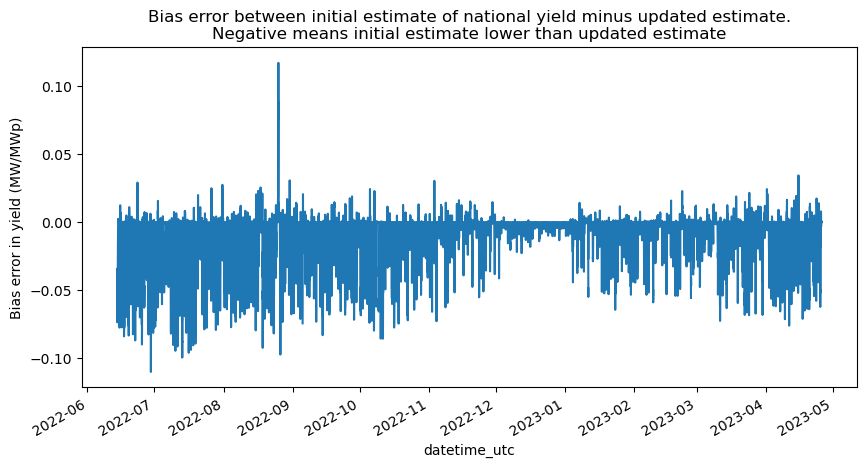

In [26]:
ax = error.plot()
ax.set_title("Bias error between initial estimate of national yield minus updated estimate.\nNegative means initial estimate lower than updated estimate")
ax.set_ylabel("Bias error in yield (MW/MWp)");

In [27]:
error.mean()

-0.008939050117671425

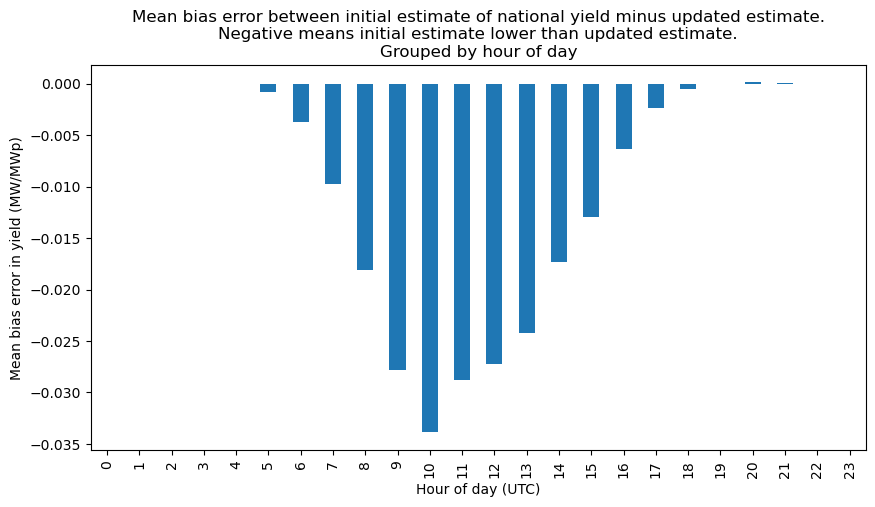

In [30]:
ax = error.groupby(error.index.hour).mean().plot.bar(figsize=(10, 5))
ax.set_title("Mean bias error between initial estimate of national yield minus updated estimate.\nNegative means initial estimate lower than updated estimate.\nGrouped by hour of day")
ax.set_ylabel("Mean bias error in yield (MW/MWp)")
ax.set_xlabel("Hour of day (UTC)");

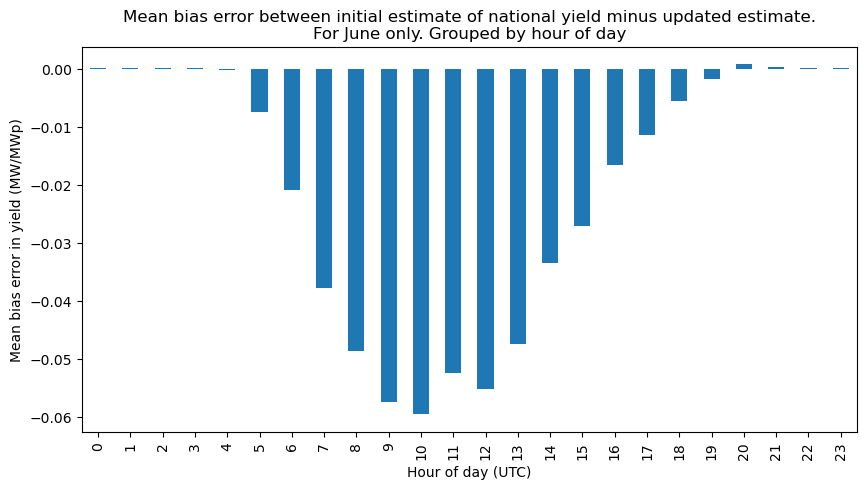

In [42]:
bias_error_for_month = error.loc[error.index.month == 6]
ax = bias_error_for_month.groupby(bias_error_for_month.index.hour).mean().plot.bar(figsize=(10, 5))
ax.set_title("Mean bias error between initial estimate of national yield minus updated estimate.\nFor June only. Grouped by hour of day")
ax.set_ylabel("Mean bias error in yield (MW/MWp)")
ax.set_xlabel("Hour of day (UTC)");

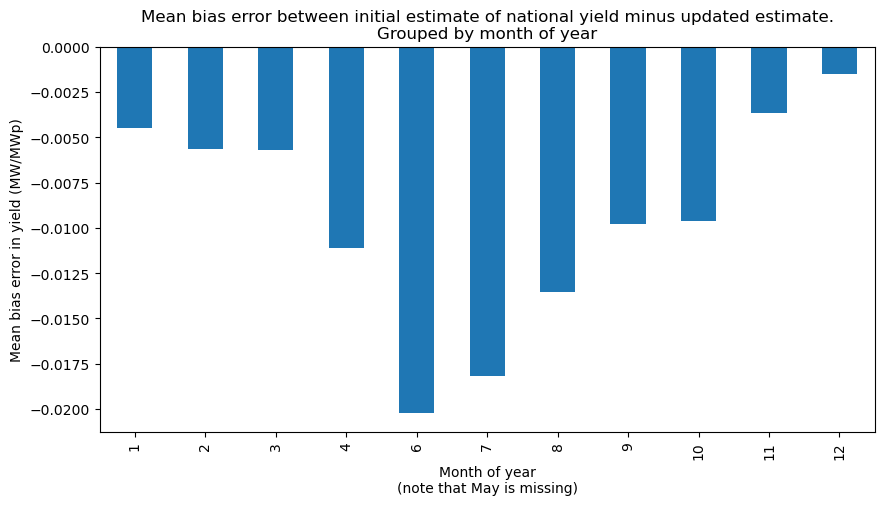

In [33]:
ax = error.groupby(error.index.month).mean().plot.bar(figsize=(10, 5))
ax.set_title("Mean bias error between initial estimate of national yield minus updated estimate.\nGrouped by month of year")
ax.set_ylabel("Mean bias error in yield (MW/MWp)")
ax.set_xlabel("Month of year\n(note that May is missing)");

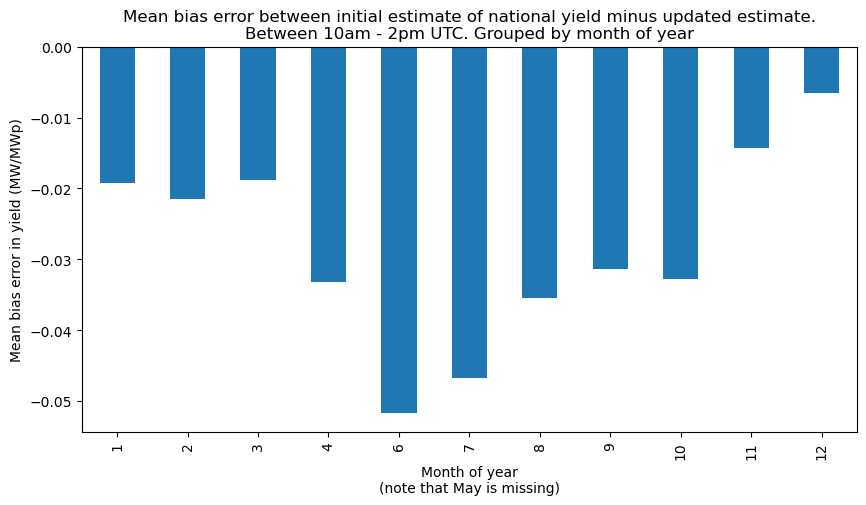

In [43]:
error_in_daylight = error.between_time("10:00", "14:00")
ax = error_in_daylight.groupby(error_in_daylight.index.month).mean().plot.bar(figsize=(10, 5))
ax.set_title("Mean bias error between initial estimate of national yield minus updated estimate.\nBetween 10am - 2pm UTC. Grouped by month of year")
ax.set_ylabel("Mean bias error in yield (MW/MWp)")
ax.set_xlabel("Month of year\n(note that May is missing)");

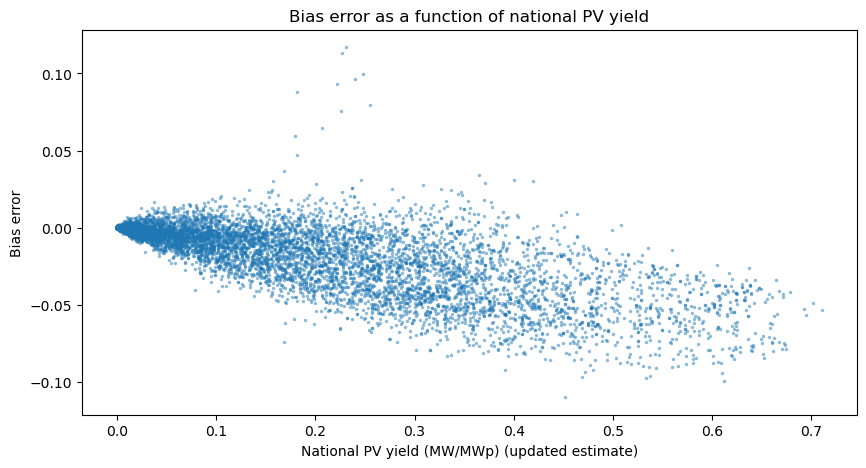

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(
    x=national_yield_from_pv_live_api.loc[error.index],
    y=error,
    alpha=0.5,
    linewidths=0,
    s=6,
)
ax.set_title("Bias error as a function of national PV yield")
ax.set_xlabel("National PV yield (MW/MWp) (updated estimate)")
ax.set_ylabel("Bias error");

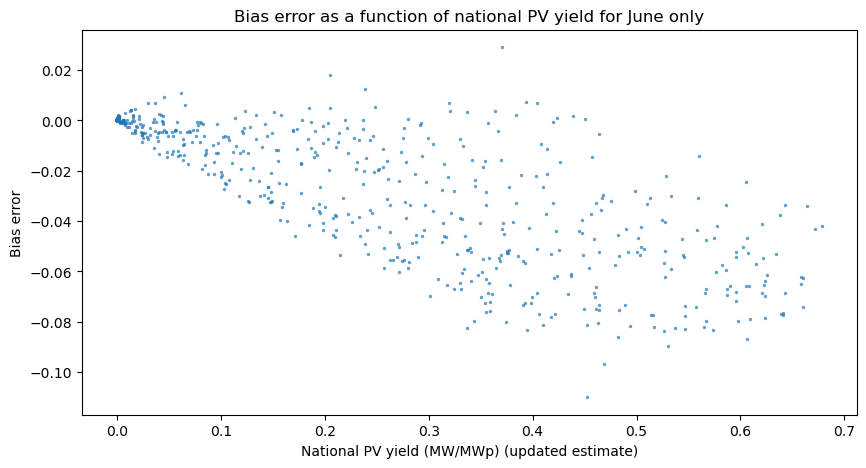

In [40]:
error_subset = error.loc[error.index.month == 6]

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(
    x=national_yield_from_pv_live_api.loc[error_subset.index],
    y=error_subset,
    alpha=0.7,
    linewidths=0,
    s=6,
)
ax.set_title("Bias error as a function of national PV yield for June only")
ax.set_xlabel("National PV yield (MW/MWp) (updated estimate)")
ax.set_ylabel("Bias error");